## Named Entity Recognition (NER) using LSTMs with Keras

In [1]:
#importing useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
#to check version of tensorflow
print('Tensorflow version:', tf.__version__)
#to check which device we have
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
#load the NER dataset
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
#since the dataset is latin1 encoded so we have to specify that
data = data.fillna(method='ffill')
#fill the empty values in dataset with the last recognized value
data.head()
#to get the idea of data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [4]:
#to get the unique number of tags and words in the corpus
print("Unique words in corpus: ",data['Word'].nunique())
print("Unique tages in corpus: ",data['Tag'].nunique())

Unique words in corpus:  35178
Unique tages in corpus:  17


In [6]:
words = list(set(data["Word"].values))
#to get the unique values of words
words.append("ENDPAD")
#adding a padding at the end of our vocablurary
num_words = len(words)

In [7]:
tags = list(set(data["Tag"].values))
#to get the unique values of tags
num_tags = len(tags)

In [8]:
num_words, num_tags
#to corss-verify, except extra word for padding is added in the words

(35179, 17)

In [12]:
#to retrieve the sentences and corresponding tags
class SentenceGetter(object):
    def __init__(self,data):
        self.n_Sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        #created the function to spearate out the words and pos and tags in tuple
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        #applying the function with sentence grouped so that each sentence and corresponding tags and pos to get
        self.sentences = [s for s in self.grouped]
        

In [13]:
#instantiated the class
getter = SentenceGetter(data)
sentences = getter.sentences

In [14]:
sentences[0]
#to check the list of a sentence that contains tuple of words,POS and tags

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [15]:
#defining the mappings between sentences and tags
words2idx = {w: i+1 for i, w in enumerate(words)}
tags2idx = {t: i for i, t in enumerate(tags)}
#to make dictionaries which contains unique values with each uniqe words and tags

In [17]:
words2idx
#to check the indices of thw words

{'Damiao': 1,
 'debating': 2,
 'Non-Sawang': 3,
 'begging': 4,
 '218': 5,
 '64.35': 6,
 'Kibembi': 7,
 'penitence': 8,
 'Expatriates': 9,
 'gravity': 10,
 'Blige': 11,
 'recaptured': 12,
 'Yung-woo': 13,
 'Territories': 14,
 'Booth': 15,
 'notice': 16,
 'undergone': 17,
 'sugarcane': 18,
 'loyalties': 19,
 'mineral': 20,
 'soon': 21,
 'Serra': 22,
 'six': 23,
 '20-year-old': 24,
 'Citgo': 25,
 'Stefano': 26,
 'Housedog': 27,
 'one-seat': 28,
 'paralyzing': 29,
 'Nathan': 30,
 'faithful': 31,
 'Valentino': 32,
 'panicked': 33,
 'hands': 34,
 'flattered': 35,
 'Eighty-eight': 36,
 'year-and-a-half': 37,
 'NBC': 38,
 'comes': 39,
 'decades-long': 40,
 'Terrorism': 41,
 'Reese': 42,
 'wished': 43,
 'orange': 44,
 'Two-time': 45,
 'Camille': 46,
 'neon': 47,
 'horizontal': 48,
 'Dutch-speaking': 49,
 'Jackson': 50,
 'El~Fasher': 51,
 'Paris': 52,
 'Nagasaki': 53,
 'al-Zarqawi': 54,
 'ash': 55,
 'Balboa': 56,
 'Navarro': 57,
 'abusing': 58,
 'arsenic': 59,
 'MARCOS': 60,
 'equalized': 61,
 '

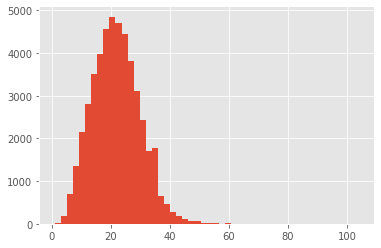

In [19]:
#padding the input sentences to fix length since neural network takes fix input sizes
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()
#to check the distribution of length of sentences

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#padding our sentences to make them at the same length of 50
max_len = 50

X = [[words2idx[w[0]] for w in s] for s in sentences]
#making the sentences to the words and then their unique values we assign to the words

X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words-1)
#padding the sentences using pad_sequence method to maxlength of 50 and padding them at end

y = [[tags2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tags2idx["O"])
#now we will encode them to one hot encoded vectors
y=[to_categorical(i,num_classes = num_tags) for i in y]

#now we created feature matrix

In [24]:
#preparing training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)
#test set is 10% of the training set

In [25]:
#useful libraries to build the LSTM model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [26]:
input_word = Input(shape=(max_len,))
#this is the input layer
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
#this will create our word embedding
model = SpatialDropout1D(0.1)(model)
#it will drop same channel from all the input, it drops 1D feature map accross the channel
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
#learning on both direction: forwards and backwards
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)
#apply dense layer to each one of the timestamps
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
#using adam optimizer and cross entropy categorical for loss

In [29]:
#to add some callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
#to see the matrics updating in the jupyter notebook

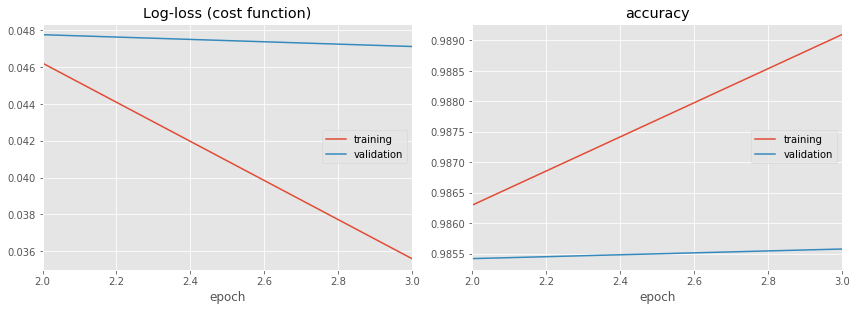

Log-loss (cost function):
training   (min:    0.036, max:    0.097, cur:    0.036)
validation (min:    0.047, max:    0.057, cur:    0.047)

accuracy:
training   (min:    0.972, max:    0.989, cur:    0.989)
validation (min:    0.983, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 191s 6ms/sample - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0471 - val_accuracy: 0.9856


In [34]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 1, verbose = 0 ,mode = 'max')
#if the validation accuracy is not improving for 1 epoch training will top
callbacks = [early_stopping, PlotLossesCallback()]
#all the callbacks in the list

#to train the model
history = model.fit(
    X_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
    callbacks = callbacks
)

In [35]:
#to evaluate the model on the test data
model.evaluate(X_test, np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0483 - accuracy: 0.9856


[0.04830349643743466, 0.98555464]

In [40]:
#let's see some of the predictions
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Predicted"))
print("-"*30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t {}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Predicted

------------------------------
The            B-org	 B-org
Associated     I-org	 I-org
Press          I-org	 I-org
says           O	 O
the            O	 O
recommendation O	 O
by             O	 O
Colonel        O	 B-org
James          B-per	 B-per
Daniel         I-per	 I-per
will           O	 O
be             O	 O
forwarded      O	 O
to             O	 O
Army           B-org	 B-org
officials      O	 O
for            O	 O
a              O	 O
final          O	 O
decision       O	 O
.              O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
commando       O	 O
comm